# Your first transient solver- diffusion equation

- [x] time stepping
- [x] time integration
- [x] initial condition
- [x] flux/surface integration
- [x] 1d/2d diffusion

Author: Yang Bai @ M3 Group

Date  : 2022.04.15

QQ group: 628204857

# Governing equation

$\frac{\partial c}{\partial t}=-\nabla\cdot\mathbf{j}$, with $\mathbf{j}=-D\nabla c$

$\dot{c}=\nabla\cdot(D\nabla c)+\dot{r}(c,\nabla c,...)=D\nabla\cdot(\nabla c)=D\Delta c=f(c)$

$c$: concentration of species or normalized concentration(molar fraction)

$D$: diffusion coefficient

# Time integration

$c^{n}$: solution of current time step (unknown)

$c^{n-1}$: solution of previous time step (known)

$\dot{c}=f(c)$ with $\dot{c}=\frac{c^{n}-c^{n-1}}{\Delta t}$

===> $\dot{c}^{n}=f(c^{n})(\mathrm{implicit, backward-euler~method~(BE)})$

===> $\dot{c}^{n}=f(c^{n-1})(\mathrm{explicit, forward-euler~method, CFL~condition})$

## weighted integration
$\int_{\Omega}\dot{c}\delta c dV=\int_{\partial\Omega}D\nabla c\cdot\vec{n}\delta cdS-\int_{\Omega}D\nabla c\nabla\delta c dV$

## time discretization
### use BE
$\int_{\Omega}\frac{c^{n}-c^{n-1}}{\Delta t}\delta c dV=\int_{\partial\Omega}D\nabla c^{n}\cdot\vec{n}\delta cdS-\int_{\Omega}D\nabla c^{n}\nabla\delta c dV$, $-D\nabla c^{n}\cdot\vec{n}=j_{0}$

### use FE
$\int_{\Omega}\frac{c^{n}-c^{n-1}}{\Delta t}\delta c dV=\int_{\partial\Omega}D\nabla c^{n-1}\cdot\vec{n}\delta cdS-\int_{\Omega}D\nabla c^{n-1}\nabla\delta c dV$, $-D\nabla c^{n-1}\cdot\vec{n}=j_{0}$

## K matrix and right hand side F (BE)
$K=\int_{\Omega}\frac{1}{\Delta t}N^{J}N^{I}dV+\int_{\Omega}D\nabla N^{J}\nabla N^{I}dV$

$F=\int_{\Omega}\frac{c^{n-1}}{\Delta t}N^{I}dV-\int_{\partial\Omega}j_{0}N^{I}dS$

# Diffusion in 1d case

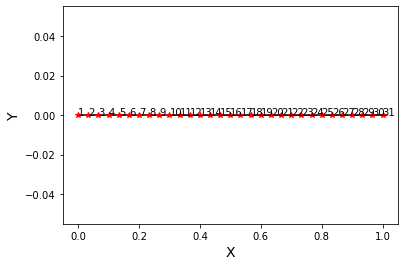

In [1]:
from FEToy.mesh.lagrange1dmesh import mesh1d
from FEToy.fe.shapefun import shape1d
from FEToy.fe.gaussrule import gausspoint1d
from FEToy.postprocess.Result import ResultIO # to csv file
import numpy as np

# define your mesh
my1dmesh=mesh1d(nx=10,xmax=1.0,meshtype='edge4')
my1dmesh.createmesh()
my1dmesh.plotmesh(withnode=True,withnodeid=True)

#define your shape fun and gauss points
shp=shape1d(meshtype='edge4')
shp.update()

qpoints=gausspoint1d(ngp=3)
qpoints.creategausspoint()

$$K=\int_{\Omega}\frac{1}{\Delta t}N^{J}N^{I}dV+\int_{\Omega}D\nabla N^{J}\nabla N^{I}dV$$
$$F=\int_{\Omega}\frac{c^{n-1}}{\Delta t}N^{I}dV-\int_{\partial\Omega}j_{0}N^{I}dS$$

In [2]:
# define your parameters
D=0.5        # diffusion coefficient
dt=1.0e-3    # time step size
totalstep=20 # the total time step
j0=0.005      # flux

nDofs=my1dmesh.nodes*1
K=np.zeros((nDofs,nDofs))
F=np.zeros(nDofs)
cold=np.zeros(nDofs) # solution in previous step
c=np.zeros(nDofs)    # solution in current step

# apply initial condition
cold[:]=0.001

# define a csv output
result=ResultIO('diff1d')
result.save2csv(mesh=my1dmesh,solution=cold,varnamelist=['c'],step=0) # to csv file

for step in range(totalstep):
    # init your k and rhs
    K[:,:]=0.0;F[:]=0.0
    for e in range(my1dmesh.elements):
        elconn=my1dmesh.elementconn[e,:]  # local element connectivity
        nodes=my1dmesh.nodecoords[elconn] # node coordinates of local element
        # now we can do the integration
        for gp in range(qpoints.ngp):
            xi=qpoints.gpcoords[gp,1] # 1->xi, 2->eta
            w =qpoints.gpcoords[gp,0] # weight
        
            shp_val,shp_grad,j=shp.calc(xi,nodes) # j->mapping from x->xi
            JxW=j*w # the weight times the determinate of jacobian transformation
            # gradc=0.0
            # for i in range(my1dmesh.nodesperelement):
            #     iInd=elconn[i]
            #     gradc+=shp_grad[i]*c[iInd]
            # now we can calculate the F term
            for i in range(my1dmesh.nodesperelement):
                iInd=elconn[i]
                # assemble to global F
                F[iInd]+=(cold[iInd]/dt)*shp_val[i]*JxW
                # now we can calculate the K matrix
                for j in range(my1dmesh.nodesperelement):
                    jInd=elconn[j]
                    K[iInd,jInd]+=(1.0/dt)*shp_val[j]*shp_val[i]*JxW\
                                 +D*shp_grad[j]*shp_grad[i]*JxW
    # apply the flux, in 1d case(bc elemt is 0-d), you don't need surface integration
    iInd=my1dmesh.bcnodeids['right']
    F[iInd]+=j0
    
    # solve the equation
    c=np.linalg.solve(K,F) # current solution
    cold[:]=c[:] # update solution
    # result.save2csv(mesh=my1dmesh,solution=cold,varnamelist=['c'],step=step+1)
    # result.save2vtu(mesh=my1dmesh,solution=cold,varnamelist=['c'],step=step+1)
    print('step=%5d finished!'%(step+1))

write result to diff1d-000000.csv
step=    1 finished!
step=    2 finished!
step=    3 finished!
step=    4 finished!
step=    5 finished!
step=    6 finished!
step=    7 finished!
step=    8 finished!
step=    9 finished!
step=   10 finished!
step=   11 finished!
step=   12 finished!
step=   13 finished!
step=   14 finished!
step=   15 finished!
step=   16 finished!
step=   17 finished!
step=   18 finished!
step=   19 finished!
step=   20 finished!


# Diffusion in 2d case

write result to diff2d-000000.vtu
write result to diff2d-000001.vtu
step=    1 finished!
write result to diff2d-000002.vtu
step=    2 finished!
write result to diff2d-000003.vtu
step=    3 finished!
write result to diff2d-000004.vtu
step=    4 finished!
write result to diff2d-000005.vtu
step=    5 finished!
write result to diff2d-000006.vtu
step=    6 finished!
write result to diff2d-000007.vtu
step=    7 finished!
write result to diff2d-000008.vtu
step=    8 finished!
write result to diff2d-000009.vtu
step=    9 finished!
write result to diff2d-000010.vtu
step=   10 finished!
write result to diff2d-000011.vtu
step=   11 finished!
write result to diff2d-000012.vtu
step=   12 finished!
write result to diff2d-000013.vtu
step=   13 finished!
write result to diff2d-000014.vtu
step=   14 finished!
write result to diff2d-000015.vtu
step=   15 finished!
write result to diff2d-000016.vtu
step=   16 finished!
write result to diff2d-000017.vtu
step=   17 finished!
write result to diff2d-000018.v

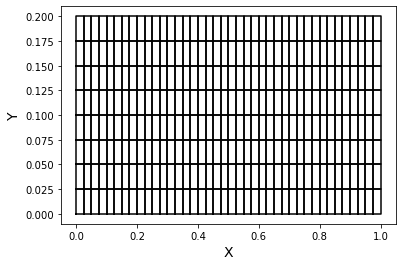

In [6]:
from FEToy.mesh.lagrange2dmesh import mesh2d
from FEToy.fe.shapefun import shape1d
from FEToy.fe.shapefun import shape2d
from FEToy.fe.gaussrule import gausspoint1d
from FEToy.fe.gaussrule import gausspoint2d
from FEToy.postprocess.Result import ResultIO
import numpy as np

# define your mesh
my2dmesh=mesh2d(nx=40,ny=8,xmax=1.0,ymax=0.2,meshtype='quad4')
my2dmesh.createmesh()
my2dmesh.plotmesh()

#define your shape fun and gauss points
shp1d=shape1d(meshtype='edge2')
shp1d.update()

# 1--5--2
# |     |
# 6  8--9 
# |     |
# 3--7--4
shp2d=shape2d(meshtype='quad4')
shp2d.update()

qpoints1d=gausspoint1d(ngp=3)
qpoints1d.creategausspoint()

qpoints2d=gausspoint2d(ngp=3) # for quad9, you need ngp>=3!
qpoints2d.creategausspoint()

############################################
# define your parameters
D=0.5        # diffusion coefficient
dt=1.0e-2    # time step size
totalstep=100 # the total time step
j0=0.005      # flux

nDofs=my2dmesh.nodes*1
K=np.zeros((nDofs,nDofs))
F=np.zeros(nDofs)
cold=np.zeros(nDofs) # solution in previous step
c=np.zeros(nDofs)    # solution in current step

# apply initial condition
cold[:]=0.001
# cold= np.random.normal(0.5, 0.02, nDofs)

# define a csv output
result=ResultIO('diff2d')
# result.save2csv(mesh=my2dmesh,solution=cold,varnamelist=['c'],step=0)
result.save2vtu(mesh=my2dmesh,solution=cold,varnamelist=['c'],step=0)
for step in range(totalstep):
    # init your k and F
    K[:,:]=0.0;F[:]=0.0
    for e in range(my2dmesh.elements):
        elconn=my2dmesh.elementconn[e,:]
        nodes=my2dmesh.nodecoords[elconn,:]
        # now we can do the integration
        for gp in range(qpoints2d.ngp2):
            xi =qpoints2d.gpcoords[gp,1] # 1->xi, 2->eta
            eta=qpoints2d.gpcoords[gp,2] # 1->xi, 2->eta
            w  =qpoints2d.gpcoords[gp,0] # weight
        
            shp_val,shp_grad,j=shp2d.calc(xi,eta,nodes[:,0],nodes[:,1]) # xi,eta,x,y
            JxW=j*w # the weight times the determinate of jacobian transformation
            # now we can calculate the F term
            for i in range(my2dmesh.nodesperelement):
                iInd=elconn[i]
                # assemble to global F
                F[iInd]+=(cold[iInd]/dt)*shp_val[i]*JxW
                # now we can calculate the K matrix
                for j in range(my2dmesh.nodesperelement):
                    jInd=elconn[j]
                    K[iInd,jInd]+=(1.0/dt)*shp_val[j]*shp_val[i]*JxW\
                                 +D*(shp_grad[j,0]*shp_grad[i,0]\
                                    +shp_grad[j,1]*shp_grad[i,1])*JxW
    # apply the flux, now you need the surface integration
    bcelmt=my2dmesh.bcconn['right'] # we want to apply the flux on the right side
    for e in range(np.shape(bcelmt)[0]):
        elconn=bcelmt[e,:]
        nodes=my2dmesh.nodecoords[elconn,:]
        for gp in range(qpoints1d.ngp):
            xi =qpoints1d.gpcoords[gp,1] # 1->xi, 2->eta
            w  =qpoints1d.gpcoords[gp,0] # weight
        
            shp_val,shp_grad,j=shp1d.calc(xi,nodes[:,1]) # for left side, you need 'y'
            JxW=j*w # the weight times the determinate of jacobian transformation
            # now we can calculate the F term
            for i in range(len(elconn)):
                iInd=elconn[i]
                # assemble to global F
                F[iInd]+=j0*shp_val[i]*JxW
        
    
    # solve the equation
    c=np.linalg.solve(K,F)
    cold[:]=c[:] # update solution
    # result.save2csv(mesh=my2dmesh,solution=cold,varnamelist=['c'],step=step+1)
    result.save2vtu(mesh=my2dmesh,solution=cold,varnamelist=['c'],step=step+1)
    print('step=%5d finished!'%(step+1))